In [1]:
import synthetic_data
import numpy as np


# context_generator = synthetic_data.BullsEyeContexts(  )
# context_generator = synthetic_data.MixtureContexts(  )

##### train and test data:

context_generator = synthetic_data.QuinticContexts(  )

X_train, y_train = None, None
X_test, y_test = None, None

for _ in range(10000):
    norm_context, distribution = context_generator.get_context()
    outcome = np.random.choice( 2 , p = distribution ) 
    X_train = norm_context if X_train is None else np.concatenate((X_train, norm_context), axis=0)
    y_train = [[outcome]] if y_train is None else np.concatenate( (y_train, [[outcome]]), axis=0)

for _ in range(10000):
    norm_context, distribution = context_generator.get_context()
    outcome = np.random.choice( 2 , p = distribution ) 
    X_test = norm_context if X_test is None else np.concatenate((X_test, norm_context), axis=0)
    y_test = [[outcome]] if y_test is None else np.concatenate( (y_test, [[outcome]]), axis=0)

##### deployment data:

context_generator = synthetic_data.QuinticContexts(  )
X_depl, y_depl = None, None

for _ in range(10000):
    norm_context, distribution = context_generator.get_context( 0.15 )
    outcome = np.random.choice( 2 , p = distribution ) 
    X_depl = norm_context if X_depl is None else np.concatenate((X_depl, norm_context), axis=0)
    y_depl = [[outcome]] if y_depl is None else np.concatenate( (y_depl, [[outcome]]), axis=0)

print( X_train.shape , y_train.shape )
print( X_test.shape , y_test.shape )
print( X_depl.shape , y_depl.shape )

(10000, 2) (10000, 1)
(10000, 2) (10000, 1)
(10000, 2) (10000, 1)


In [13]:
import torch
import torch.nn as nn
import torch.optim as optim

class Network(nn.Module):
    def __init__(self,  d, m):
        super(Network, self).__init__()
        self.fc1 = nn.Linear(d, m)
        self.activate1 = nn.Tanh() #nn.ReLU()
        self.fc2 = nn.Linear(m, m)
        self.activate2 = nn.Tanh() #nn.ReLU()
        self.fc3 = nn.Linear(m, m)
        self.activate3 = nn.Tanh() #nn.ReLU()
        self.fc4 = nn.Linear(m, 1)
        nn.init.normal_(self.fc1.weight, mean=0, std=0.1)
        nn.init.normal_(self.fc2.weight, mean=0, std=0.1)
        nn.init.normal_(self.fc3.weight, mean=0, std=0.1)
        nn.init.normal_(self.fc4.weight, mean=0, std=0.1)
        nn.init.zeros_(self.fc1.bias)
        nn.init.zeros_(self.fc2.bias)
        nn.init.zeros_(self.fc3.bias)
        nn.init.zeros_(self.fc4.bias)
    def forward(self, x):
        x = self.fc4( self.activate3( self.fc3( self.activate2( self.fc2( self.activate1( self.fc1( x ) ) ) ) ) ) )
        # x = self.fc2( self.activate1( self.fc1(x) ) ) 
        return x

# Set the random seed for reproducibility
torch.manual_seed(41)

# Create the model instance
model = Network(2, 20).to('cuda')

# Define the loss function (mean squared error) and optimizer
# optimizer = optim.SGD(model.parameters(), lr=0.01)
optimizer = optim.Adam(model.parameters(), lr=1e-1, weight_decay = 0 )
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, 0.99)

for _ in range(1000):

    model.train()

    outputs = model( torch.tensor(X_train).to('cuda').float() ) 
    loss = nn.MSELoss()(outputs, torch.tensor(y_train).to('cuda').float() )
    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    ### test and deployment loss:
    model.eval()
    with torch.no_grad():
        outputs_test = model( torch.tensor(X_test).to('cuda').float() ).to('cpu').float() 
        loss_test = nn.MSELoss()(outputs_test, torch.tensor(y_test).to('cpu').float() )

        outputs_depl = model( torch.tensor(X_depl).to('cuda').float() ).to('cpu').float() 
        loss_depl = nn.MSELoss()(outputs_depl, torch.tensor(y_depl).to('cpu').float() )

    if _ % 10 == 0 :
        scheduler.step()
        print(f'Epoch {_}, Train loss: {loss.item():.4f}, Test loss: {loss_test.item():.4f}, Depl loss: {loss_depl.item():.4f}')


torch.save(model, 'quintic_shift.pth')

Epoch 0, Train loss: 0.4934, Test loss: 0.2305, Depl loss: 0.2049
Epoch 10, Train loss: 0.0910, Test loss: 0.0581, Depl loss: 0.0904
Epoch 20, Train loss: 0.0718, Test loss: 0.0707, Depl loss: 0.0826
Epoch 30, Train loss: 0.0480, Test loss: 0.0459, Depl loss: 0.0563
Epoch 40, Train loss: 0.0361, Test loss: 0.0360, Depl loss: 0.0622
Epoch 50, Train loss: 0.0222, Test loss: 0.0219, Depl loss: 0.0525
Epoch 60, Train loss: 0.0169, Test loss: 0.0177, Depl loss: 0.0540
Epoch 70, Train loss: 0.0138, Test loss: 0.0144, Depl loss: 0.0549
Epoch 80, Train loss: 0.0118, Test loss: 0.0123, Depl loss: 0.0558
Epoch 90, Train loss: 0.0103, Test loss: 0.0106, Depl loss: 0.0586
Epoch 100, Train loss: 0.0092, Test loss: 0.0095, Depl loss: 0.0613
Epoch 110, Train loss: 0.0084, Test loss: 0.0087, Depl loss: 0.0628
Epoch 120, Train loss: 0.0078, Test loss: 0.0081, Depl loss: 0.0637
Epoch 130, Train loss: 0.0073, Test loss: 0.0077, Depl loss: 0.0650
Epoch 140, Train loss: 0.0084, Test loss: 0.0107, Depl loss

Text(0.5, 1.0, 'Training Decision Boundary and test data')

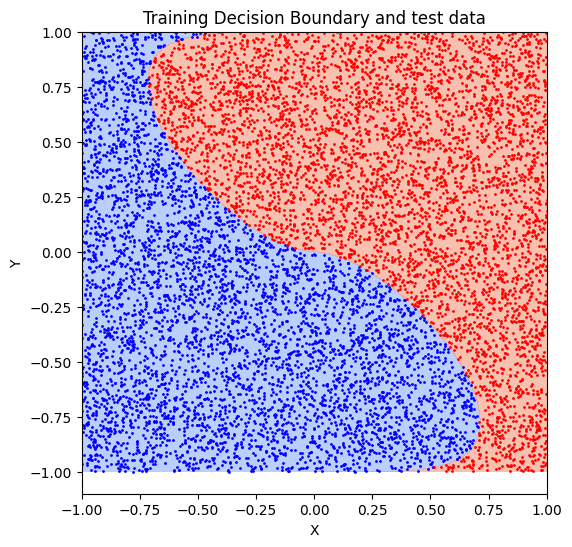

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as Fun

plt.figure(figsize=(6, 6))

# Define the range of x and y values for the grid
x_min, x_max = -1, 1
y_min, y_max = -1, 1

# Generate a grid of points
num_points = 1000  # You can adjust this to change the resolution of the plot
x_values = np.linspace(x_min, x_max, num_points)  
y_values = np.linspace(y_min, y_max, num_points)  
x_grid, y_grid = np.meshgrid(x_values, y_values)

# Compute the decision boundary for the grid of points
decision_boundary_grid = context_generator.decision_boundary_function(x_grid, y_grid, 0)
plt.contourf(x_grid, y_grid, decision_boundary_grid, levels=1, alpha=0.6, cmap=plt.cm.coolwarm)

contexts = np.array( [ context_generator.denormalize(i) for i in X_test ] ).squeeze(1)
pred_action0 = [ i[0] if i[0] > 0.5 else np.nan for i in outputs_test  ]
indices_predaction0 = np.where(~np.isnan(pred_action0))[0]
pred_action1 = [ i[0] if i[0] <= 0.5 else np.nan for i in outputs_test  ]
indices_predaction1 = np.where(~np.isnan(pred_action1))[0]

plt.scatter(contexts[indices_predaction0][:,0], contexts[indices_predaction0][:,1], s = 1, color='blue', label='Predicted Points')
plt.scatter(contexts[indices_predaction1][:,0], contexts[indices_predaction1][:,1], s = 1, color='red', label='Predicted Points')

# Add labels and title to the plot
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Training Decision Boundary and test data')

Text(0.5, 1.0, 'Deployment Decision Boundary')

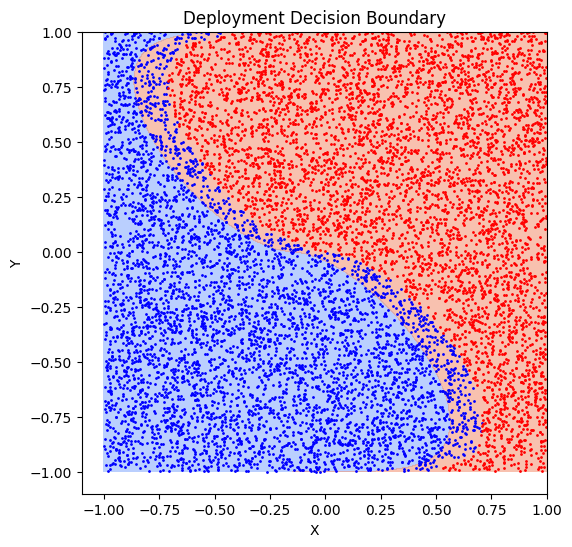

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as Fun

plt.figure(figsize=(6, 6))

# Define the range of x and y values for the grid
x_min, x_max = -1, 1
y_min, y_max = -1, 1

# Generate a grid of points
num_points = 1000  # You can adjust this to change the resolution of the plot
x_values = np.linspace(x_min, x_max, num_points)  
y_values = np.linspace(y_min, y_max, num_points)  
x_grid, y_grid = np.meshgrid(x_values, y_values)

# Compute the decision boundary for the grid of points
decision_boundary_grid = context_generator.decision_boundary_function(x_grid, y_grid, 0.15)
plt.contourf(x_grid, y_grid, decision_boundary_grid, levels=1, alpha=0.6, cmap=plt.cm.coolwarm)

contexts = np.array( [ context_generator.denormalize(i) for i in X_depl ] ).squeeze(1)
pred_action0 = [ i[0] if i[0] > 0.5 else np.nan for i in outputs_depl  ]
indices_predaction0 = np.where(~np.isnan(pred_action0))[0]
pred_action1 = [ i[0] if i[0] <= 0.5 else np.nan for i in outputs_depl  ]
indices_predaction1 = np.where(~np.isnan(pred_action1))[0]

plt.scatter(contexts[indices_predaction0][:,0], contexts[indices_predaction0][:,1], s = 1, color='blue', label='Predicted Points')
plt.scatter(contexts[indices_predaction1][:,0], contexts[indices_predaction1][:,1], s = 1, color='red', label='Predicted Points')

# Add labels and title to the plot
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Deployment Decision Boundary')

In [ ]:
import cbpside
import rand_cbpside
import neural_lin_cbpside_disjoint
import rand_neural_lin_cbpside_disjoint

import games
import synthetic_data
import numpy as np
import random

seed = 0
np.random.seed(seed)
torch.manual_seed(seed)
random.seed(seed)


horizon = 2500
lbd_neural = 0
lbd_reg = 1
# game = games.apple_tasting( )
game = games.label_efficient( )

